In [ ]:
#!/usr/bin/env python3
import pandas as pd
from pathlib import Path
import re
from typing import List

import torch
from sentence_transformers import SentenceTransformer, util

In [140]:
def read_text(path: Path) -> str:
    # Read as UTF-8; replace undecodable bytes so the comparison can proceed
    return path.read_text(encoding="utf-8", errors="replace")

In [141]:
def strip_comments_and_whitespace(text: str) -> str:
    """
    Text-only minifier:
      1) For each line, drop everything from first '#' to EOL.
      2) Remove ALL whitespace chars.
    NOTE: Treats '#' inside strings as comment starts (simple & fast).
    """
    lines = []
    for line in text.splitlines():
        hash_idx = line.find("#")
        if hash_idx != -1:
            line = line[:hash_idx]
        lines.append(line)
    no_comments = "".join(lines)
    return re.sub(r"\s+", "", no_comments)

In [142]:
# ------------------ Embedding long texts with chunking ------------------ #
def chunk_by_tokens(text: str, tokenizer, max_tokens: int, stride: int) -> List[str]:
    """
    Split `text` into overlapping chunks by tokenizer tokens, then decode each
    chunk back to text for SentenceTransformer.encode.
    """
    # Tokenize once (no specials) then slice token ids.
    toks = tokenizer.encode(text, add_special_tokens=False)
    n = len(toks)
    if n == 0:
        return [""]  # keep shape consistent

    chunks = []
    i = 0
    while i < n:
        window = toks[i : i + max_tokens]
        chunk_text = tokenizer.decode(window, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        chunks.append(chunk_text)
        if i + max_tokens >= n:
            break
        i += max(max_tokens - stride, 1)
    return chunks

In [143]:
@torch.no_grad()
def embed_long_text(model: SentenceTransformer, text: str, max_tokens: int = 384, stride: int = 64) -> torch.Tensor:
    """
    Embed long text by averaging L2-normalized embeddings over token-based chunks.
    """
    tokenizer = model.tokenizer
    chunks = chunk_by_tokens(text, tokenizer, max_tokens=max_tokens, stride=stride)
    # Encode chunks -> normalized embeddings (SentenceTransformer returns normalized if normalize_embeddings=True is set)
    # We’ll explicitly normalize after.
    embs = model.encode(
        chunks,
        batch_size=8,
        convert_to_tensor=True,
        show_progress_bar=False,
        normalize_embeddings=False,
    )
    # L2-normalize each chunk vector
    embs = torch.nn.functional.normalize(embs, p=2, dim=1)
    # Average then normalize again
    mean_emb = embs.mean(dim=0, keepdim=True)
    mean_emb = torch.nn.functional.normalize(mean_emb, p=2, dim=1)
    return mean_emb.squeeze(0)  # shape: (d,)

In [144]:
def cosine_similarity(a: torch.Tensor, b: torch.Tensor) -> float:
    return torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

In [145]:


def read_csv_file(file_name: str) -> pd.DataFrame:
    if "__file__" in globals():
        base_dir = Path(__file__).resolve().parent
    else:
        base_dir = Path.cwd()

    csv_path = base_dir / file_name

    print(f"📄 CSV path: {csv_path}")
    print(f"🔍 Trying to read: {csv_path.resolve()}")

    if not csv_path.exists():
        raise FileNotFoundError(f"❌ CSV file not found: {csv_path}")

    try:
        df = pd.read_csv(csv_path)
        print(f"✅ Loaded CSV with {len(df)} rows × {len(df.columns)} columns.")
    except Exception as e:
        raise RuntimeError(f"Failed to read CSV: {e}")

    return df


In [146]:
df_decompiled_syntax_errors = read_csv_file('../dataset/decompiled_syntax_errors.csv')

📄 CSV path: /home/diogenes/pylingual_colaboration/pylingual_download/code/utils/../dataset/decompiled_syntax_errors.csv
🔍 Trying to read: /home/diogenes/pylingual_colaboration/pylingual_download/code/dataset/decompiled_syntax_errors.csv
✅ Loaded CSV with 383 rows × 5 columns.


In [147]:
results = []

print("=" * 80)
print("🧩 Starting decompiled file comparison")
print("=" * 80)

total_rows = len(df_decompiled_syntax_errors)
print(f"Total records to process: {total_rows}\n")

    # Load model (CPU by default; will use GPU if available & torch detects it)
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"Model: {model}")
for idx, row in df_decompiled_syntax_errors.iterrows():
    file_hash = row["file_hash"]
    file_name = row["file"]
    raw_name = file_name.split(".")[0].replace("decompiled_", "")
    missing = False
    # Paths
    path1 = Path(f"../results/experiment_outputs/20251110T012915Z/daf95c71075048e1b3458c3c109344fd/{file_hash}/syntax_repaired_{file_name}")
    path2 = Path(f"/home/diogenes/pylingual_colaboration/pypi_downloaded/{file_hash}/{file_name}")
    path3 = Path(f"/home/diogenes/pylingual_colaboration/pypi_downloaded/{file_hash}/{raw_name}.py")

    print("-" * 80)
    print(f"[{idx+1}/{total_rows}] 🔍 Comparing files for hash: {file_hash}")
    print(f"  📄 File 1   : {path1.name}")
    print(f"  📄 File 2   : {path2.name}")
    print(f"  📄 File 3   : {path3.name}")

    for fp in (path1, path2, path3):
        if not Path(fp).is_file():
            missing = True

    if missing:
        print(f"⚠️ One or more files are missing. Skipping this record.")
        
        continue
    # Load & (optionally) preprocess
    def prep(path: Path) -> str:
        text = read_text(path)
        return strip_comments_and_whitespace(text)

    s1 = prep(path1)
    s2 = prep(path2)
    s3 = prep(path3)

    # Embed (with chunking for long files)
    e1 = embed_long_text(model, s1, max_tokens=512, stride=128)
    e2 = embed_long_text(model, s2, max_tokens=512, stride=128)
    e3 = embed_long_text(model, s3, max_tokens=512, stride=128)

    # Cosine similarity & distance
    sim_31 = cosine_similarity(e3, e1)
    sim_32 = cosine_similarity(e3, e2)
    dist_32 = 1.0 - sim_32
    dist_31 = 1.0 - sim_31
    print(f"Cosine similarity (file2 vs file1): {sim_32:.6f}  | distance: {dist_32:.6f}")
    print(f"Cosine similarity (file3 vs file1): {sim_31:.6f}  | distance: {dist_31:.6f}")

    results.append({
        "file_hash": file_hash,
        "decompiled_file_name": file_name,
        "raw_file_name": path3.name,
        "d_lookup_vs_decompiled_similarity": sim_32,
        "d_lookup_vs_repaired_similarity": sim_31,
        "d_lookup_vs_decompiled_distance": dist_32,
        "d_lookup_vs_repaired_distance": dist_31,
    })

    print("-" * 80)

    # Uncomment to test only one iteration
    # break

# --- Convert results to DataFrame ---
results_df = pd.DataFrame(results)
print("\n" + "=" * 80)
print("🏁 Finished processing all decompiled file comparisons.")
print("=" * 80)

print("\n📊 Results summary:")
print(results_df.head())




🧩 Starting decompiled file comparison
Total records to process: 383



Token indices sequence length is longer than the specified maximum sequence length for this model (7559 > 256). Running this sequence through the model will result in indexing errors


Model: SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)
--------------------------------------------------------------------------------
[1/383] 🔍 Comparing files for hash: 025bcf101990c51854d7caa7c53055cdd6e9119e6c5e1764245bcc37ecb1ae92f73c434a962f41411729e6b5a722479e7c5736b316c6f007328524c6bd0f2531
  📄 File 1   : syntax_repaired_decompiled_jvccommands.cpython-312.py
  📄 File 2   : decompiled_jvccommands.cpython-312.py
  📄 File 3   : jvccommands.py
Cosine similarity (file2 vs file1): 0.965605  | distance: 0.034395
Cosine similarity (file3 vs file1): 0.970253  | distance: 0.029747
---------------------------

In [148]:
# --- Optional: Save results ---
output_csv = Path("../dataset/decompiled_comparison_results_cosine.csv")
results_df.to_csv(output_csv, index=False)
print(f"\n💾 Results saved to: {output_csv.resolve()}")


💾 Results saved to: /home/diogenes/pylingual_colaboration/pylingual_download/code/dataset/decompiled_comparison_results_cosine.csv


In [149]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

def plot_dualcolor_bars_by_index(
    df: pd.DataFrame,
    output_dir: Path | str = "plots",
    col1: str = "d_lookup_vs_decompiled",
    col2: str = "d_lookup_vs_repaired",
    title: str = "Edit Distance per File Index",
    color1: str = "#1f77b4",  # blue
    color2: str = "#ff7f0e",  # orange
    fig_width: float = 16,
    fig_height: float = 8,
    bar_width: float = 0.9,
    overlay_scale: float = 0.7,
    alpha1: float = 0.8,
    alpha2: float = 0.9,
    show: bool = True,
    save: bool = True,
):
    """
    Plot one large bar per file index, divided into two colored layers.

    The wider base bar shows col1 (e.g. decompiled distance),
    and a narrower overlay bar shows col2 (e.g. repaired distance).

    Args:
        df: DataFrame with numeric columns col1 and col2.
        output_dir: Directory to save the plot.
        col1, col2: Column names for comparison.
        title: Plot title.
        color1, color2: Colors for the two metrics.
        fig_width, fig_height: Figure dimensions in inches.
        bar_width: Width of base bars (0–1).
        overlay_scale: Fractional width for overlay bars.
        alpha1, alpha2: Transparency of the bars.
        show, save: Whether to display and/or save the plot.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    if col1 not in df.columns or col2 not in df.columns:
        print(f"❌ Missing one or both columns: {col1}, {col2}")
        print("Available columns:", list(df.columns))
        return

    x = np.arange(len(df))
    vals1 = df[col1].to_numpy()
    vals2 = df[col2].to_numpy()

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Base (wider) bar
    ax.bar(
        x,
        vals1,
        width=bar_width,
        color=color1,
        alpha=alpha1,
        label=f"{col1} (base)",
        edgecolor="black",
        linewidth=0.5,
    )

    # Overlay (narrower) bar
    ax.bar(
        x,
        vals2,
        width=bar_width * overlay_scale,
        color=color2,
        alpha=alpha2,
        label=f"{col2} (overlay)",
        edgecolor="black",
        linewidth=0.3,
    )

    # Style
    ax.set_xlabel("File Index", fontsize=14)
    ax.set_ylabel("Edit Distance", fontsize=14)
    ax.set_title(title, fontsize=16, pad=12, weight="bold")
    ax.legend(fontsize=12)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    if save:
        out_path = output_dir / "edit_distance_dualcolor_large.png"
        plt.savefig(out_path, dpi=250)
        print(f"💾 Saved plot → {out_path.resolve()}")

    if show:
        plt.show()
    else:
        plt.close()


💾 Saved plot → /home/diogenes/pylingual_colaboration/pylingual_download/code/results/figures/edit_distance_dualcolor_large.png


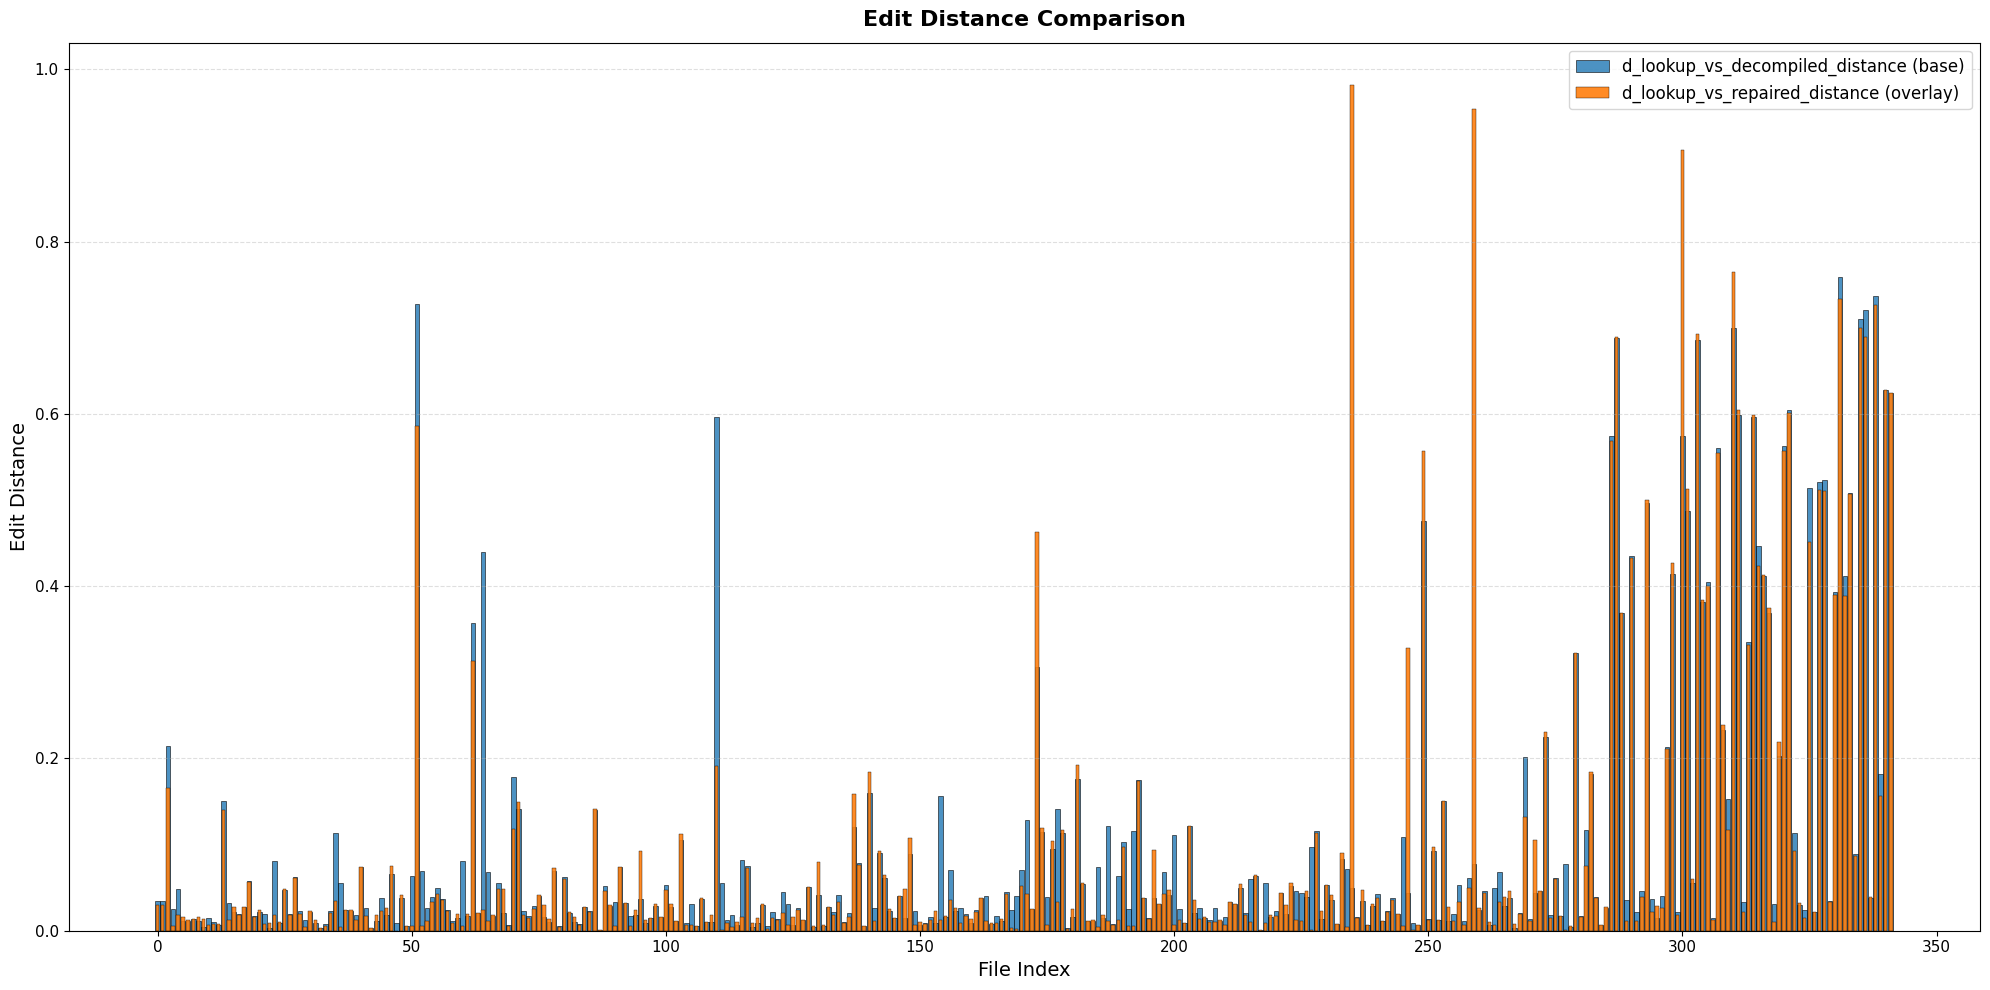

In [150]:
plot_dualcolor_bars_by_index(
    results_df,
    output_dir="../results/figures",
    col1="d_lookup_vs_decompiled_distance",
    col2="d_lookup_vs_repaired_distance",
    title="Edit Distance Comparison",
    fig_width=20,     # make the figure very wide
    fig_height=10,    # and tall
    bar_width=0.9,    # make bars thick
    overlay_scale=0.75,  # slightly narrower overlay
    show=True
)



In [151]:
# plot_dualcolor_bars_by_index(
#     results_df,
#     output_dir="../results/figures",
#     col1="d_lookup_vs_decompiled_similarity",
#     col2="d_lookup_vs_repaired_similarity",
#     title="Edit Distance Comparison (Wider Bars & Larger Plot)",
#     fig_width=20,     # make the figure very wide
#     fig_height=10,    # and tall
#     bar_width=0.9,    # make bars thick
#     overlay_scale=0.75,  # slightly narrower overlay
#     show=True
# )

